# Carey's experiment

2-block SBM G ~ SBM(n, pi, B)  
B = [p^2, pq; pq, q^2]  
p, q = 1/3, 1/4

just setting an even number n=500 of nodes in each community, since code for drawing node communities stochastically isn't as accessible (e.g., I don't know where it is... and I think it shouldn't change much? maybe I'm wrong?)

so the pi inputted into `vfun` = 1/2 in this case, I think? so that it can be a scalar?  

nodes in community 1 drawn from N(q, vfun(pi, q, p, ci=1)/n)  
nodes in community 2 drawn from N(q, vfun(pi, q, p, ci=2)/n)  

Text(0.5, 1.0, 'Covariates')

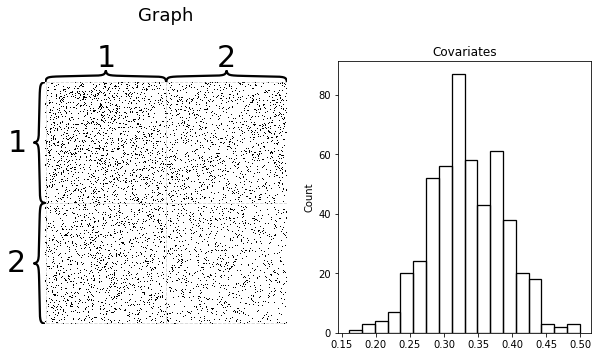

In [1]:
import numpy as np
from scipy.stats import norm
from graspologic.simulations import sbm
from graspologic.plot import binary_heatmap
import seaborn as sns
from matplotlib import pyplot as plt
np.random.seed(1)

def vfun(pi, p, q, ci=1):
    if ci==1:
        num = pi*p**4*(1-p**2) + (1-pi)*p*q**3*(1-p*q)
    else:
        num = pi*p**3*q*(1-p*q) + (1-pi)*q**4*(1-q**2)
    
    denom = ((pi*p**2 + (1-pi)*q**2))**2
    return num / denom

def make_community(mu, sig, n=500):
    return np.random.normal()
    return norm.rvs(mu, sig, size=n)

def gen_covariates(p, q, pi, n=250):
    c1 = np.random.normal(p, np.sqrt(vfun(pi, q, p, ci=1)/n), size=n)
    c2 = np.random.normal(p, np.sqrt(vfun(1-pi, p, q, ci=2)/n), size=n)
    covariates = np.concatenate((c1, c2))
    
    return covariates

p, q = 1/3, 1/4
pi = 1/2
n = 500
nvec = [int(n*pi), int(n*(1-pi))]
B = np.array([[p**2, p*q],
              [p*q, q**2]])

A, labels = sbm(nvec, B, return_labels=True)
labels += 1

X = gen_covariates(p, q, pi, n=int(n*pi))

fig, axs = plt.subplots(1, 2, figsize=(10,5))
binary_heatmap(A, ax=axs[0], inner_hier_labels=labels, cbar=False, title="Graph")
sns.histplot(X, ax=axs[1], fill=False, color='k').set_title("Covariates")

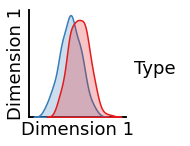

In [2]:
from graspologic.embed import CovariateAssistedEmbed as CASE
from graspologic.plot import pairplot

case = CASE(n_components=1)
latents = case.fit_transform(A, covariates=X)

pairplot(latents, labels=labels)

## default alpha isn't super reasonable

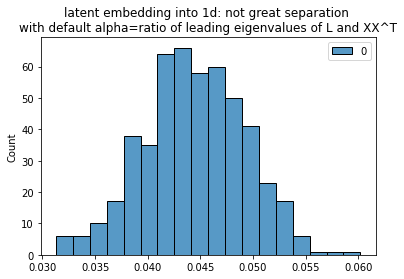

In [3]:
ax = sns.histplot(latents)
ax.set_title("latent embedding into 1d: not great separation \nwith default alpha=ratio of leading eigenvalues of L and XX^T");

/Users/alex/.pyenv/versions/3.8.5/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'into 2 dimensions'}>

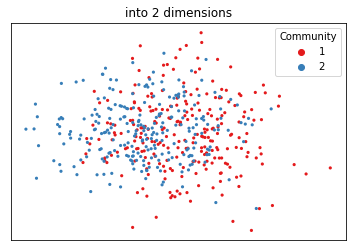

In [4]:
def plot_latents(latent_positions, *, title, labels, ax=None):
    if ax is None:
        ax = plt.gca()
    plot = sns.scatterplot(latent_positions[:, 0], latent_positions[:, 1], hue=labels, 
                           linewidth=0, s=10, ax=ax, palette="Set1")
    plot.set_title(title, wrap=True);
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.legend(loc="upper right", title="Community")
    
    return plot

case = CASE(n_components=2)
latents = case.fit_transform(A, covariates=X)

plot_latents(latents, title="into 2 dimensions", labels=labels)

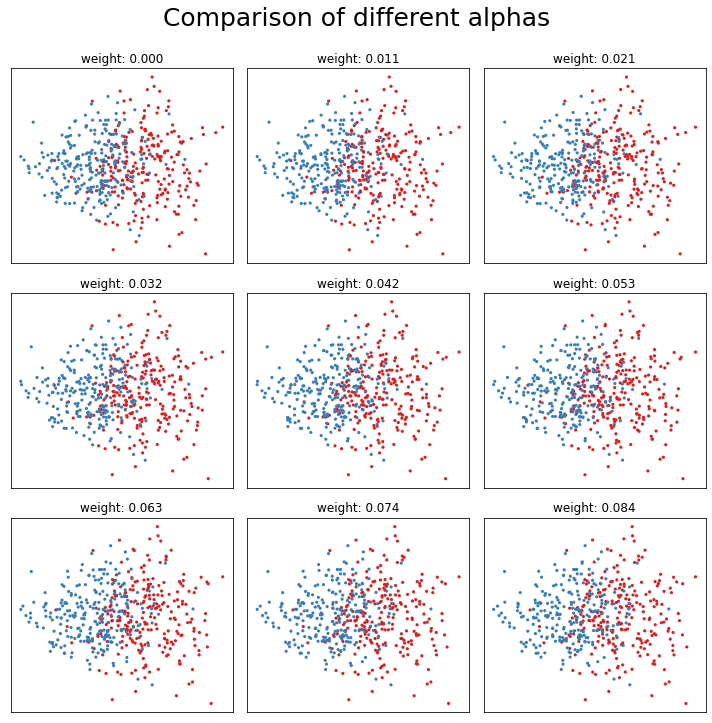

In [14]:
from warnings import filterwarnings
filterwarnings("ignore")

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
alphas = np.linspace(0,0.2,num=20).tolist()+[0.5]
# for a, ax in zip(np.geomspace(10e-5, 100, num=9), axs.flat):
for a, ax in zip(alphas, axs.flat):
    case = CASE(n_components=2, alpha=a)
    l_ = case.fit_transform(A, covariates=X)
    plot_latents(l_, title=f"weight: {a:.3f}", labels=labels, ax=ax)
    ax.get_legend().remove()
    
fig.suptitle(r"Comparison of different alphas", y=1, fontsize=25);
plt.tight_layout()

## embedding with best alpha I can see there

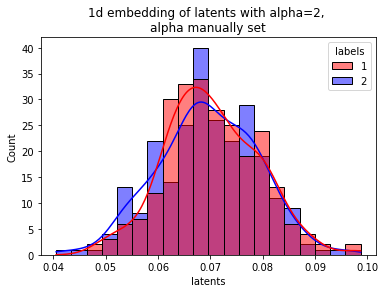

In [15]:
import pandas as pd

alpha = 2
case = CASE(n_components=1, alpha=alpha)
latents = case.fit_transform(A, covariates=X)

data = pd.DataFrame({"labels": labels, "latents": latents.squeeze()})
ax = sns.histplot(data, x="latents", bins=20, kde=True, hue="labels", 
                  palette=["red", "blue"])
ax.set_title("1d embedding of latents with alpha=2, \nalpha manually set");

## ARI plot

I think Teresa passed-to-ranks inside her version of CASE, graspologic implementation doesn't do that (should it?)

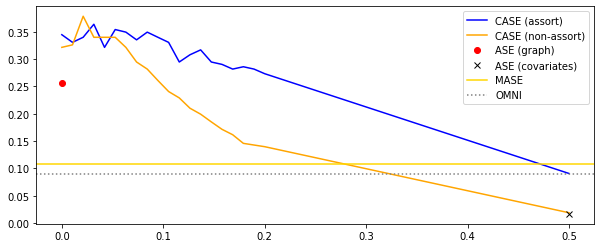

In [19]:
from sklearn.metrics import adjusted_rand_score, rand_score
from sklearn.mixture import GaussianMixture as GMM
from graspologic.embed import AdjacencySpectralEmbed as ASE
from graspologic.embed import OmnibusEmbed
from graspologic.embed import MultipleASE as MASE

def ARI(embedding, true_labels):
    gmm = GMM(n_components=2, covariance_type="full")
    pred = gmm.fit_predict(embedding)
    return adjusted_rand_score(true_labels, pred)

p, q = 1/3, 1/4

aris_case_assort = {}
aris_case_nonassort = {}
aris_ase_cov = {}
aris_omni = {}
aris_mase = {}
alphas = np.linspace(0,0.2,num=20).tolist()+[0.5]
for alpha in alphas:
    
    # CASE assort
    case = CASE(n_components=1, alpha=alpha, embedding_alg="assortative")
    latents = case.fit_transform(A, covariates=X)
    aris_case_assort[alpha] = ARI(latents, labels)
    
    # CASE nonassort
    case = CASE(n_components=1, alpha=alpha, embedding_alg="non-assortative")
    latents = case.fit_transform(A, covariates=X)
    aris_case_nonassort[alpha] = ARI(latents, labels)

# ASE A
ase = ASE(n_components=1)
latents = ase.fit_transform(A)
ari_ase_A = ARI(latents, labels)

# ASE covariates
ase = ASE(n_components=1)
latents = ase.fit_transform(np.outer(X, X))
ari_ase_cov = ARI(latents, labels)

# OMNI
omni = OmnibusEmbed(n_components=1)
Zhat = omni.fit_transform([A, np.outer(X, X)])
latents = .5*Zhat[0] + .5*Zhat[1]
ari_omni = ARI(latents, labels)

# MASE
mase = MASE(n_components=1)
latents = mase.fit_transform([A, np.outer(X,X)])
ari_mase = ARI(latents, labels)


    
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(aris_case_assort.keys(), aris_case_assort.values(), c="blue", label="CASE (assort)")
ax.plot(aris_case_nonassort.keys(), aris_case_nonassort.values(), c="orange", label="CASE (non-assort)")
ax.plot(0, ari_ase_A,'ro', label='ASE (graph)')
ax.plot(alphas[-1], ari_ase_cov, 'kx', label='ASE (covariates)')
ax.axhline(ari_mase, color='gold',linestyle='-', label='MASE')
ax.axhline(ari_omni, color='grey',linestyle=':', label='OMNI')

plt.legend(loc="best")